In [66]:
"""
@author: Philip Ruthig, Uni Leipzig
"""
import numpy as np
import scipy.ndimage as ndi
import math as m
import matplotlib.pyplot as plt
import tifffile as tf
import os

def chunk_generator(img_shape,chunk_size,overlap):
    '''
    Returns a sequence of coordinates every time it is called with next() that can be used to cycle through 3D arrays in blocks.

    Inputs:
    img_shape: image shape(z,y,x)
    chunk_size: desired chunk size (z,y,x)
    overlap: overlap (in pixels) on every side of the chunk

    Outputs:
    6 integers giving the start & end coordinates in all axes in the following order:
    xstart, xend, ystart, yend, zstart, zend

    to do:
        rest of image calculation, uneven boundaries
        n-dimensional image compatibility
    '''

    z_start = 0 
    z_end   = chunk_size[0]
    y_start = 0
    y_end   = chunk_size[1]
    x_start = 0
    x_end   = chunk_size[2]
    
    while x_end <= img_shape[2]: #if x_end exceeds x boundary of image, all is done

        yield (z_start,z_end,y_start,y_end,x_start,x_end)

        z_start = z_start + chunk_size[0]-2*overlap
        z_end   = z_start + chunk_size[0]
        
        # if z_end exceeds img shape: move y_start (and reset z_start)
        if z_end > img_shape[0]:
            y_start = y_start + chunk_size[1]-2*overlap
            y_end   = y_start + chunk_size[1]
            z_start = 0
            z_end   = chunk_size[0]
        
        # if z_end AND y_end exceed img shape: move x_start (and reset y_start and z_start)
        if y_end > img_shape[1]:
            x_start = x_start + chunk_size[2]-2*overlap
            x_end   = x_start + chunk_size[2]
            z_start = 0
            z_end   = chunk_size[0]
            y_start = 0
            y_end   = chunk_size[1]

    yield z_start,z_end,y_start,y_end,x_start,x_end

# script options
sigma=2
vmin_single = -5
vmax_single = 5
vmin_avg=-1.3
vmax_avg=1.3#
subset=True
cutoff=2 #pixels in Z to include in distance 1d plot

# # script options
# sigma=2
# vmin_single = -3.5
# vmax_single = 3.5
# vmin_avg=-1
# vmax_avg=0.7#
# subset=True
# cutoff=2 #pixels in Z to include in distance 1d plot

# get image paths


#paths must be in L-R-L-R order
img_paths_all = os.listdir("processed/")
img_paths = []
for filename in img_paths_all:
    if "dist.tif" in filename and "hucd" in filename:
        img_paths.append(filename)

list_img_labels=[]
list_lr_diffs=[]

In [67]:
list_img=[]
for img_path in img_paths:
    # open image
    img_file = tf.imread("processed/" + img_path)
    # img_file = img_file.astype('uint16')
    # rotate picture 90° right (left AC) or 270° right (right AC)
    if "_L_" in img_path:
        rot_temp_resultarray = np.rot90(img_file,k=3,axes=(1,2))
        list_img_labels.append(img_path[:7])
    else:
        rot_temp_resultarray = np.rot90(img_file,k=1,axes=(1,2))
        list_img_labels.append(img_path[:7])
    # append image to list
    list_img.append(rot_temp_resultarray)

In [68]:
# blur images, z score and calculate averages. 
for i,img in enumerate(list_img):
    if i == 0:
        list_img_raw=[]
        avg_left = np.zeros_like(img,dtype="float32") #initialize empty arrays
        avg_right = np.zeros_like(img,dtype="float32")
        left_raw_sum = np.zeros_like(img,dtype="float32")
        right_raw_sum = np.zeros_like(img,dtype="float32")
    
    list_img_raw.append(img)

    if "_L" in list_img_labels[i]: #add all data by hemisphere, make average
        left_raw_sum+=img
    else:
        right_raw_sum+=img
    
    img = img.astype("float32")
    img = ndi.filters.gaussian_filter(img, sigma=sigma)
    img = img - np.mean(img)
    img = img / np.std(img)
    list_img[i] = img

    if "_L" in list_img_labels[i]: #add all data by hemisphere, make average
        avg_left+=img
    else:
        avg_right+=img
    
avg_left=avg_left/i/2 #divide by number of images in data 
avg_right=avg_right/i/2
avg_diff=avg_left-avg_right #calculate average difference left-right

C:\Users\Hoellenmaschine2\AppData\Local\Temp\ipykernel_5004\1913459833.py:18: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  img = ndi.filters.gaussian_filter(img, sigma=sigma)


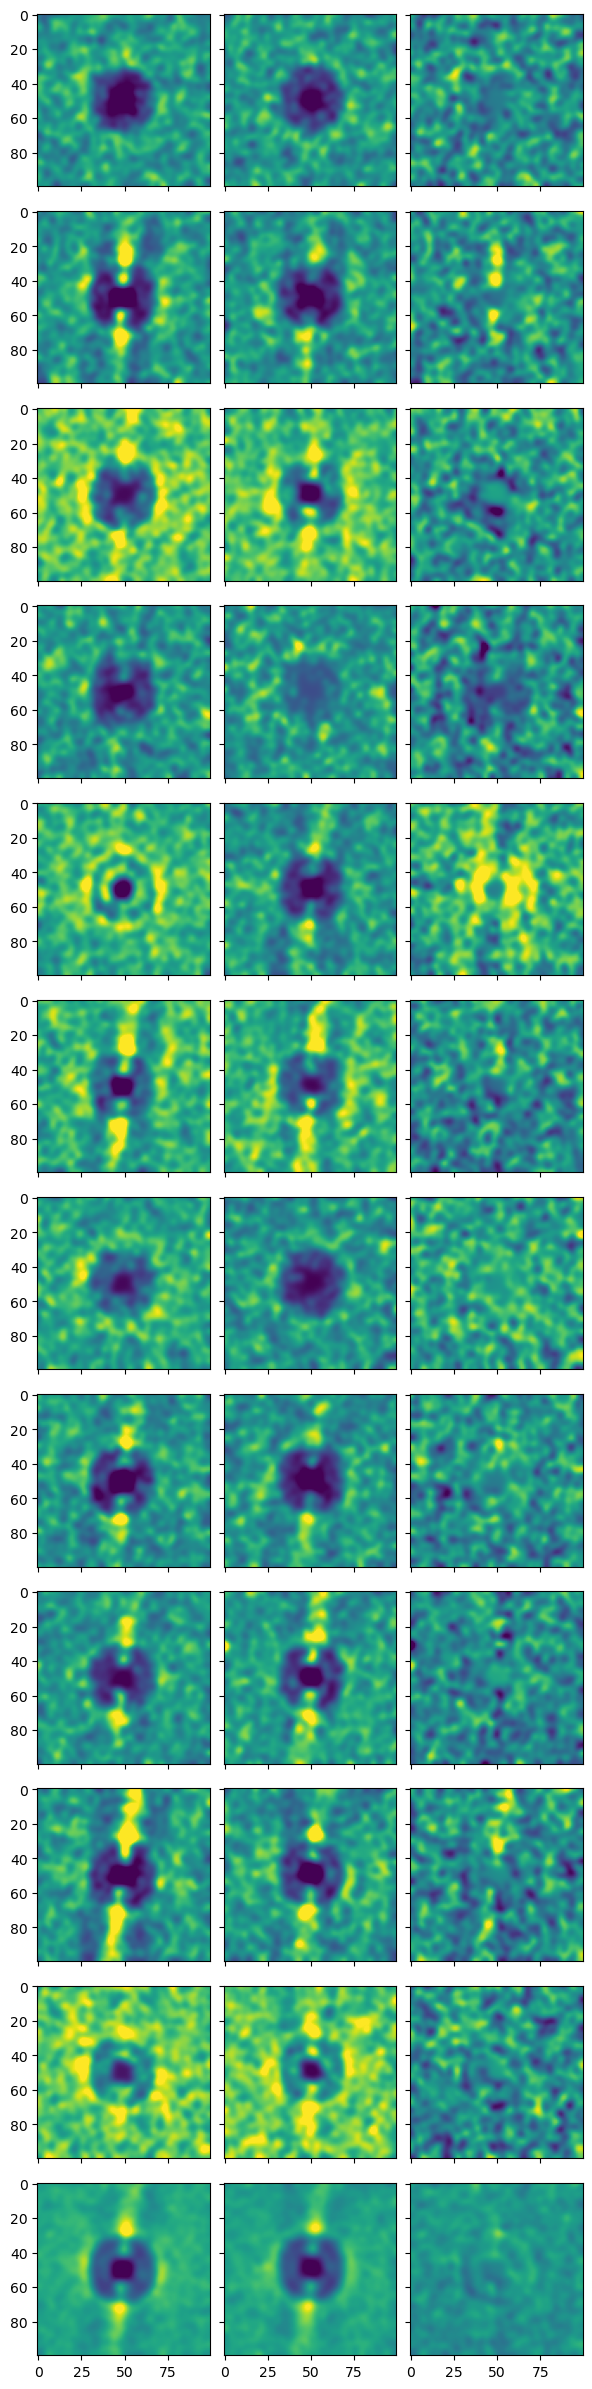

In [69]:
#
# Fig1
#
# calculate differences between each left and right AC image
for i, img in enumerate(list_img):
    if "_L" in list_img_labels[i]: # calculate difference between left and right hemisphere of single brains
        img_diff = list_img[i]-list_img[i+1] # left minus right hemisphere
    else:
        continue
    list_lr_diffs.append(img_diff) 

# plotting l/r differences and averages
fig,ax=plt.subplots(nrows=len(img_paths)//2+1,ncols=3,sharex="all",sharey="all",figsize=(6,24))
for i, img in enumerate(list_img):
    if "_L" in list_img_labels[i]:
        ax[i//2,0].imshow(list_img[i][avg_left.shape[0]//2,:,:],vmin=vmin_single,vmax=vmax_single)#left
        temp = list_img[i][avg_left.shape[0]//2,:,:]#store current left hemisphere img in temp for difference calculation
    if "_R" in list_img_labels[i]:
        ax[i//2,1].imshow(list_img[i][avg_left.shape[0]//2,:,:],vmin=vmin_single,vmax=vmax_single)#right
        ax[i//2,2].imshow(temp-list_img[i][avg_left.shape[0]//2,:,:],vmin=vmin_single,vmax=vmax_single)#diff
ax[len(img_paths)//2,0].imshow(avg_left[avg_left.shape[0]//2,:,:],vmin=vmin_avg,vmax=vmax_avg)
ax[len(img_paths)//2,1].imshow(avg_right[avg_right.shape[0]//2,:,:],vmin=vmin_avg,vmax=vmax_avg)
ax[len(img_paths)//2,2].imshow(avg_left[avg_left.shape[0]//2,:,:]-avg_right[avg_right.shape[0]//2,:,:],vmin=vmin_avg,vmax=vmax_avg)
fig.tight_layout()
plt.show()


In [70]:
# right_raw_sum = avg_right
# right_left_sum = avg_left

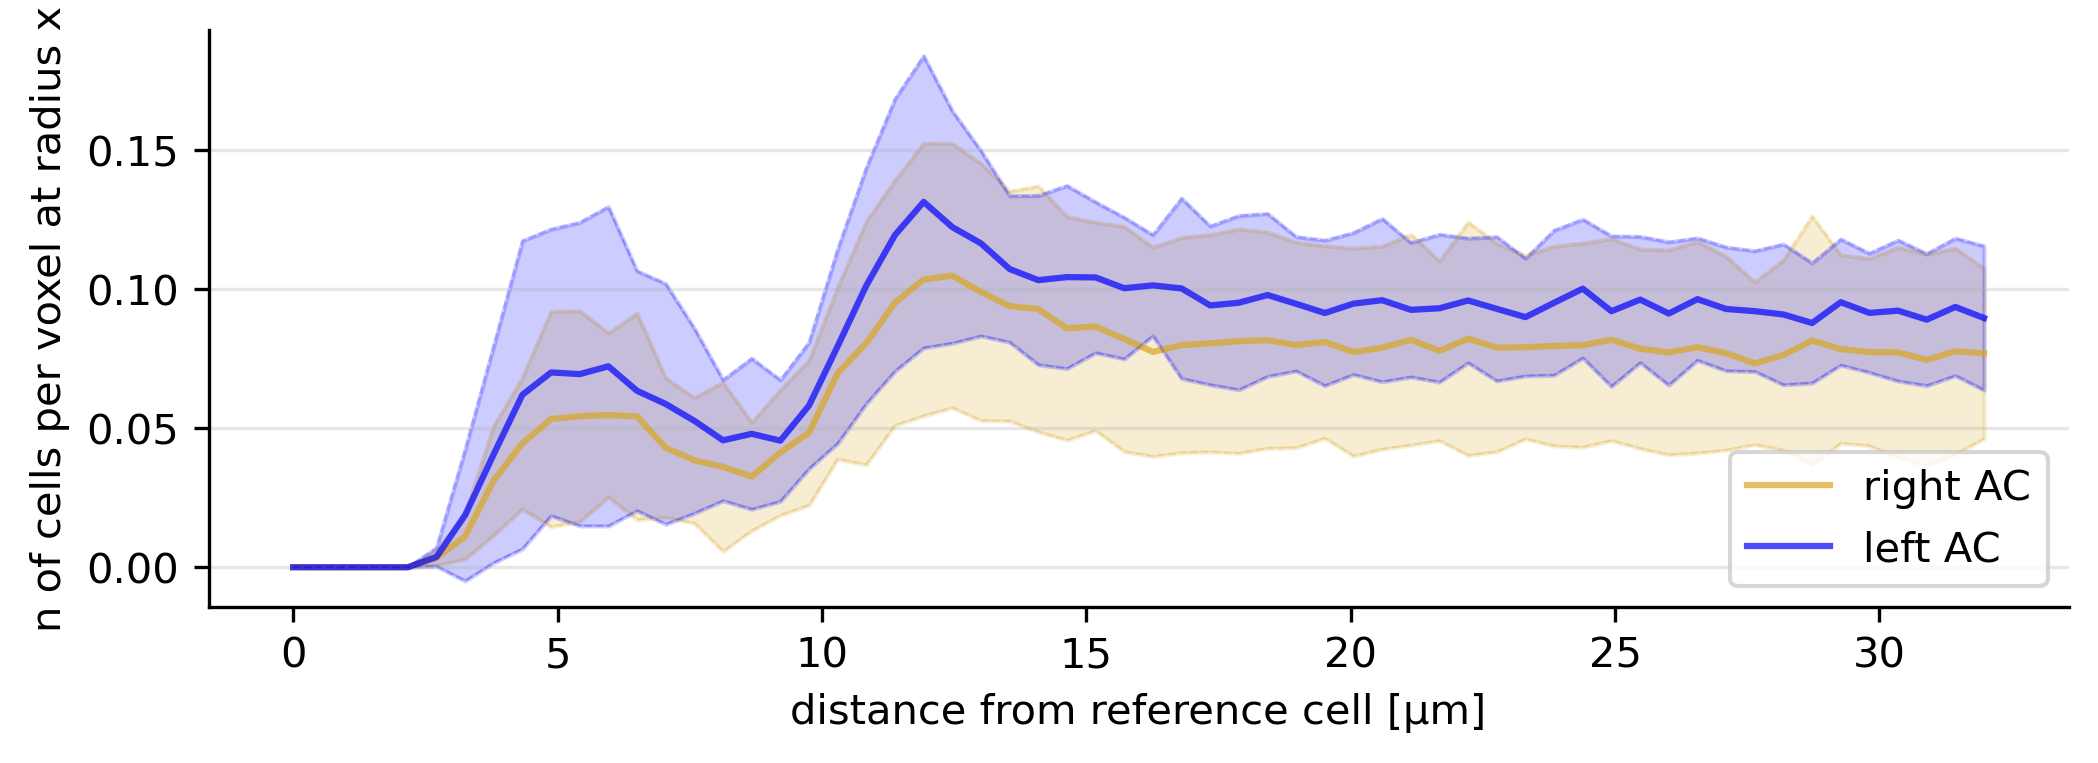

In [71]:
#
# Fig2
#

# calculate 1D array of distances to the middle cell

if subset == True: #crop images to subset
    right_raw_sum=right_raw_sum[right_raw_sum.shape[0]//2-cutoff:right_raw_sum.shape[0]//2+cutoff]
    left_raw_sum=left_raw_sum[left_raw_sum.shape[0]//2-cutoff:left_raw_sum.shape[0]//2+cutoff]
    for i, img_temp in enumerate(list_img_raw):
        list_img_raw[i]=img_temp[img_temp.shape[0]//2-cutoff:img_temp.shape[0]//2+cutoff]

coords = chunk_generator((right_raw_sum.shape),chunk_size=(1,1,1),overlap=0,)
midpoint=[right_raw_sum.shape[0]//2,right_raw_sum.shape[1]//2,right_raw_sum.shape[2]//2]
list_distance_right = np.zeros(int(m.sqrt((right_raw_sum.shape[0]//2)**2 + (right_raw_sum.shape[1]//2)**2 + (right_raw_sum.shape[2]//2)**2))+1,)
list_distance_left = np.zeros(int(m.sqrt((right_raw_sum.shape[0]//2)**2 + (right_raw_sum.shape[1]//2)**2 + (right_raw_sum.shape[2]//2)**2))+1,)

# initialize empty list and image filled with ones for normalization
list_normalization = np.zeros(int(m.sqrt((right_raw_sum.shape[0]//2)**2 + (right_raw_sum.shape[1]//2)**2 + (right_raw_sum.shape[2]//2)**2))+1,)
img_normalization = np.ones_like(right_raw_sum)

## turn sums into averages by dividing by number of images
right_raw_sum = right_raw_sum/len(img_paths)
left_raw_sum = left_raw_sum/len(img_paths)

for i in range(right_raw_sum.shape[0]*right_raw_sum.shape[1]*right_raw_sum.shape[2]):
    #set active pixel
    coord_tuple=next(coords)
    coords_active=[]
    coords_active.append(coord_tuple[0])
    coords_active.append(coord_tuple[2])
    coords_active.append(coord_tuple[4])
    # calculate distance from mid pixel to active pixel
    current_dist = m.sqrt((coords_active[0]-midpoint[0])**2 + (coords_active[1]-midpoint[1])**2 + (coords_active[2]-midpoint[2])**2)
    # readout number of cells in active pixel
    n_cells_active_right = right_raw_sum[coords_active[0],coords_active[1],coords_active[2]]
    n_cells_active_left = left_raw_sum[coords_active[0],coords_active[1],coords_active[2]]
    # add the number of active cells in the raw sum array into the list
    list_normalization[int(current_dist)]+=1
    list_distance_right[int(current_dist)]+=n_cells_active_right
    list_distance_left[int(current_dist)]+=n_cells_active_left

# normalize by amount of (possible) cell locations
list_distance_right = list_distance_right/list_normalization
list_distance_left = list_distance_left/list_normalization
# remove normalization artifact
list_distance_left[0]=0 
list_distance_right[0]=0 

single_distance_array = np.zeros((len(img_paths),len(list_distance_left)+1))

for i,current_img in enumerate(list_img_raw):
    # calculate 1d distance plots for every dist array for standard deviation
    coords = chunk_generator((list_img_raw[0].shape),chunk_size=(1,1,1),overlap=0,)
    for px in range(current_img.shape[0]*current_img.shape[1]*current_img.shape[2]):
        #set active pixel
        coord_tuple=next(coords)
        coords_active=[]
        coords_active.append(coord_tuple[0])
        coords_active.append(coord_tuple[2])
        coords_active.append(coord_tuple[4])
        # calculate distance from mid pixel to active pixel
        current_dist = m.sqrt((coords_active[0]-midpoint[0])**2 + (coords_active[1]-midpoint[1])**2 + (coords_active[2]-midpoint[2])**2)
        # readout number of cells in active pixel
        n_cells_temp = current_img[coords_active[0],coords_active[1],coords_active[2]]
        # add the number of active cells in the raw sum array into the list
        single_distance_array[i,int(current_dist)]+=n_cells_temp
    
    # normalize by amount of possible cell locations
    single_distance_array[i,:-1] = single_distance_array[i,:-1]/list_normalization
    single_distance_array[:,0] = 0

# list_std_left = [] 
# list_std_right = []
# for i,distance in enumerate(range(single_distance_array.shape[1])):
#     list_std_left.append(np.std(single_distance_array[0:10:2,i]))
#     list_std_right.append(np.std(single_distance_array[1:10:2,i]))

import scipy.stats

list_std_left = [] 
list_std_right = []
for i,distance in enumerate(range(single_distance_array.shape[1])):
    list_std_left.append(scipy.stats.sem(single_distance_array[0:10:2,i]))
    list_std_right.append(scipy.stats.sem(single_distance_array[1:10:2,i]))

fig = plt.figure(figsize=(8, 5.5), dpi=300)
ax = fig.add_subplot(2, 1, 2)
x_values = np.array(range(len(list_distance_right[:60]))) * 0.542

# Right AC with shaded area
plt.plot(x_values, list_distance_right[:60], color="goldenrod", label="right AC", alpha=0.7, lw=1.5)
plt.fill_between(x_values, list_distance_right[:60] - list_std_right[:60], list_distance_right[:60] + list_std_right[:60], color="goldenrod", alpha=0.2)
plt.plot(x_values, list_distance_right[:60] - list_std_right[:60], color="goldenrod", linestyle='--', linewidth=0.5, alpha=0.2)
plt.plot(x_values, list_distance_right[:60] + list_std_right[:60], color="goldenrod", linestyle='--', linewidth=0.5, alpha=0.2)

# Left AC with shaded area
plt.plot(x_values, list_distance_left[:60], color="blue", label="left AC", alpha=0.7, lw=1.5)
plt.fill_between(x_values, list_distance_left[:60] - list_std_left[:60], list_distance_left[:60] + list_std_left[:60], color="blue", alpha=0.2)
plt.plot(x_values, list_distance_left[:60] - list_std_left[:60], color="blue", linestyle='--', linewidth=0.5, alpha=0.2)
plt.plot(x_values, list_distance_left[:60] + list_std_left[:60], color="blue", linestyle='--', linewidth=0.5, alpha=0.2)

plt.legend(loc="lower right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("distance from reference cell [µm]")
ax.set_ylabel("n of cells per voxel at radius x")
ax.yaxis.grid(True, alpha=0.3)
plt.show()

# # plot with errorbars
# fig = plt.figure(figsize=(8, 5.5),dpi=300)
# ax = fig.add_subplot(2, 1, 2,)
# plt.errorbar(np.array(range(len(list_distance_right[:60])))*0.542,list_distance_right[:60],yerr=list_std_right[:60],elinewidth=0.4,color="goldenrod",label="right AC",alpha=0.7,lw=2)#replace error bars
# plt.errorbar(np.array(range(len(list_distance_left[:60])))*0.542,list_distance_left[:60],yerr=list_std_left[:60],elinewidth=0.4,color="blue",label="left AC",alpha=0.7,lw=2)
# plt.legend(loc="lower right")
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xlabel("distance from reference cell [µm]")
# ax.set_ylabel("n of cells per voxel at radius x")
# ax.yaxis.grid(True,alpha=0.3)
# plt.show()

In [72]:
# plt.errorbar(np.array(range(len(list_distance_right[:60])))*0.542,list_distance_right[:60],yerr=list_std_right[:60],elinewidth=1.2,color="goldenrod",label="right AC",alpha=0.7,lw=2)#replace error bars

In [73]:
# list_std_left = []
# list_std_right = []

# for i in range(single_distance_array.shape[1]-1):
#     list_std_left.append(np.std(single_distance_array[:,i]))#L
#     list_std_right.append(np.std(single_distance_array[:,i+1]))#R

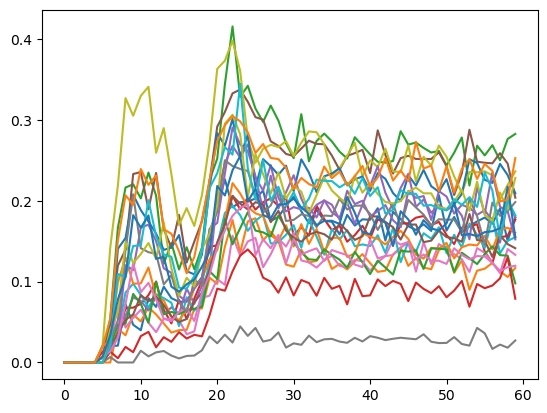

In [74]:
for i in range(single_distance_array.shape[0]):
    # if i %2 ==0:
        # continue
    plt.plot(single_distance_array[i,:60])

In [75]:
#paths must be in L-R-L-R order
img_paths_all = os.listdir("processed/")
img_paths_fig3 = []
for filename in img_paths_all:
    if "centers.tif" in filename and "hucd" in filename:
        img_paths_fig3.append(filename)


In [76]:
img = tf.imread("resaved_data_with_vc\PR013_R.tif")
img.shape
n_voxels = img.shape[0]*img.shape[2]*img.shape[3] # 0,2,3 because dimension 1 is channels. 0,2,3 is zyx
px_volume = 0.54*0.54*4 #[µm]
tissue_fraction = np.count_nonzero(img[:,0,:,:]>600)/n_voxels
tissue_fraction

0.8473841635112622

In [77]:
#
# Fig3
#

#initialize lists of cells
list_n_cells_l = []
list_n_cells_r = []

for img_path in img_paths_fig3:
    centers = tf.imread("processed/" + img_path)
    
    if "_L_" in img_path:
        list_n_cells_l.append(np.sum(centers,axis=(0,1,2)))
    else:
        list_n_cells_r.append(np.sum(centers,axis=(0,1,2)))

count_left = np.average(list_n_cells_l)/n_voxels*px_volume*1e9*tissue_fraction
count_right = np.average(list_n_cells_r)/n_voxels*px_volume*1e9*tissue_fraction
labels = ["left AC", "right AC"]

densities_l=np.array((list_n_cells_l))/n_voxels*px_volume*1e9*tissue_fraction
densities_r=np.array((list_n_cells_r))/n_voxels*px_volume*1e9*tissue_fraction

In [78]:
# define outliers by calculating IQR
differences = densities_l - densities_r
Q1 = np.percentile(differences, 25)
Q3 = np.percentile(differences, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = differences[(differences < lower_bound) | (differences > upper_bound)]
print("Outliers:", outliers)

Outliers: [57285.33934588]


In [79]:
#initialize lists of cells
list_n_cells_l = []
list_n_cells_r = []

for img_path in img_paths_fig3:
    if "PR006" in img_path:
        continue
    centers = tf.imread("processed/" + img_path)
    
    if "_L_" in img_path:
        list_n_cells_l.append(np.sum(centers,axis=(0,1,2)))
    else:
        list_n_cells_r.append(np.sum(centers,axis=(0,1,2)))

avg_density_left = np.average(list_n_cells_l)/n_voxels*px_volume*1e9*tissue_fraction
avg_density_right = np.average(list_n_cells_r)/n_voxels*px_volume*1e9*tissue_fraction
labels = ["left AC", "right AC"]

densities_l=np.array((list_n_cells_l))/n_voxels*px_volume*1e9*tissue_fraction
densities_r=np.array((list_n_cells_r))/n_voxels*px_volume*1e9*tissue_fraction

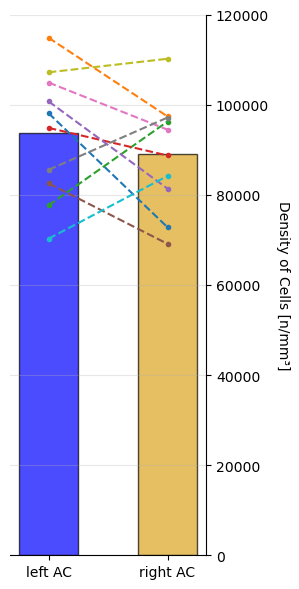

In [80]:
fig, ax = plt.subplots(figsize=(3.1, 6))
ax.bar(labels, (avg_density_left, avg_density_right), alpha=0.7, width=0.5, color=['blue', 'goldenrod'], edgecolor="black")
ax.set_ylim(0, 120000)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(True, alpha=0.3)

# Move y-axis to the right side
ax.yaxis.tick_right()

# Move ylabel to the right side
ax.yaxis.set_label_position("right")
ax.set_ylabel("Density of Cells [n/mm³]", rotation=-90, labelpad=15)

for i in range(len(densities_l)):
    plt.plot((densities_l[i], densities_r[i]), marker=".", linestyle='--', color=plt.cm.tab10(i))

plt.tight_layout()
plt.show()


In [81]:
print("done")

done


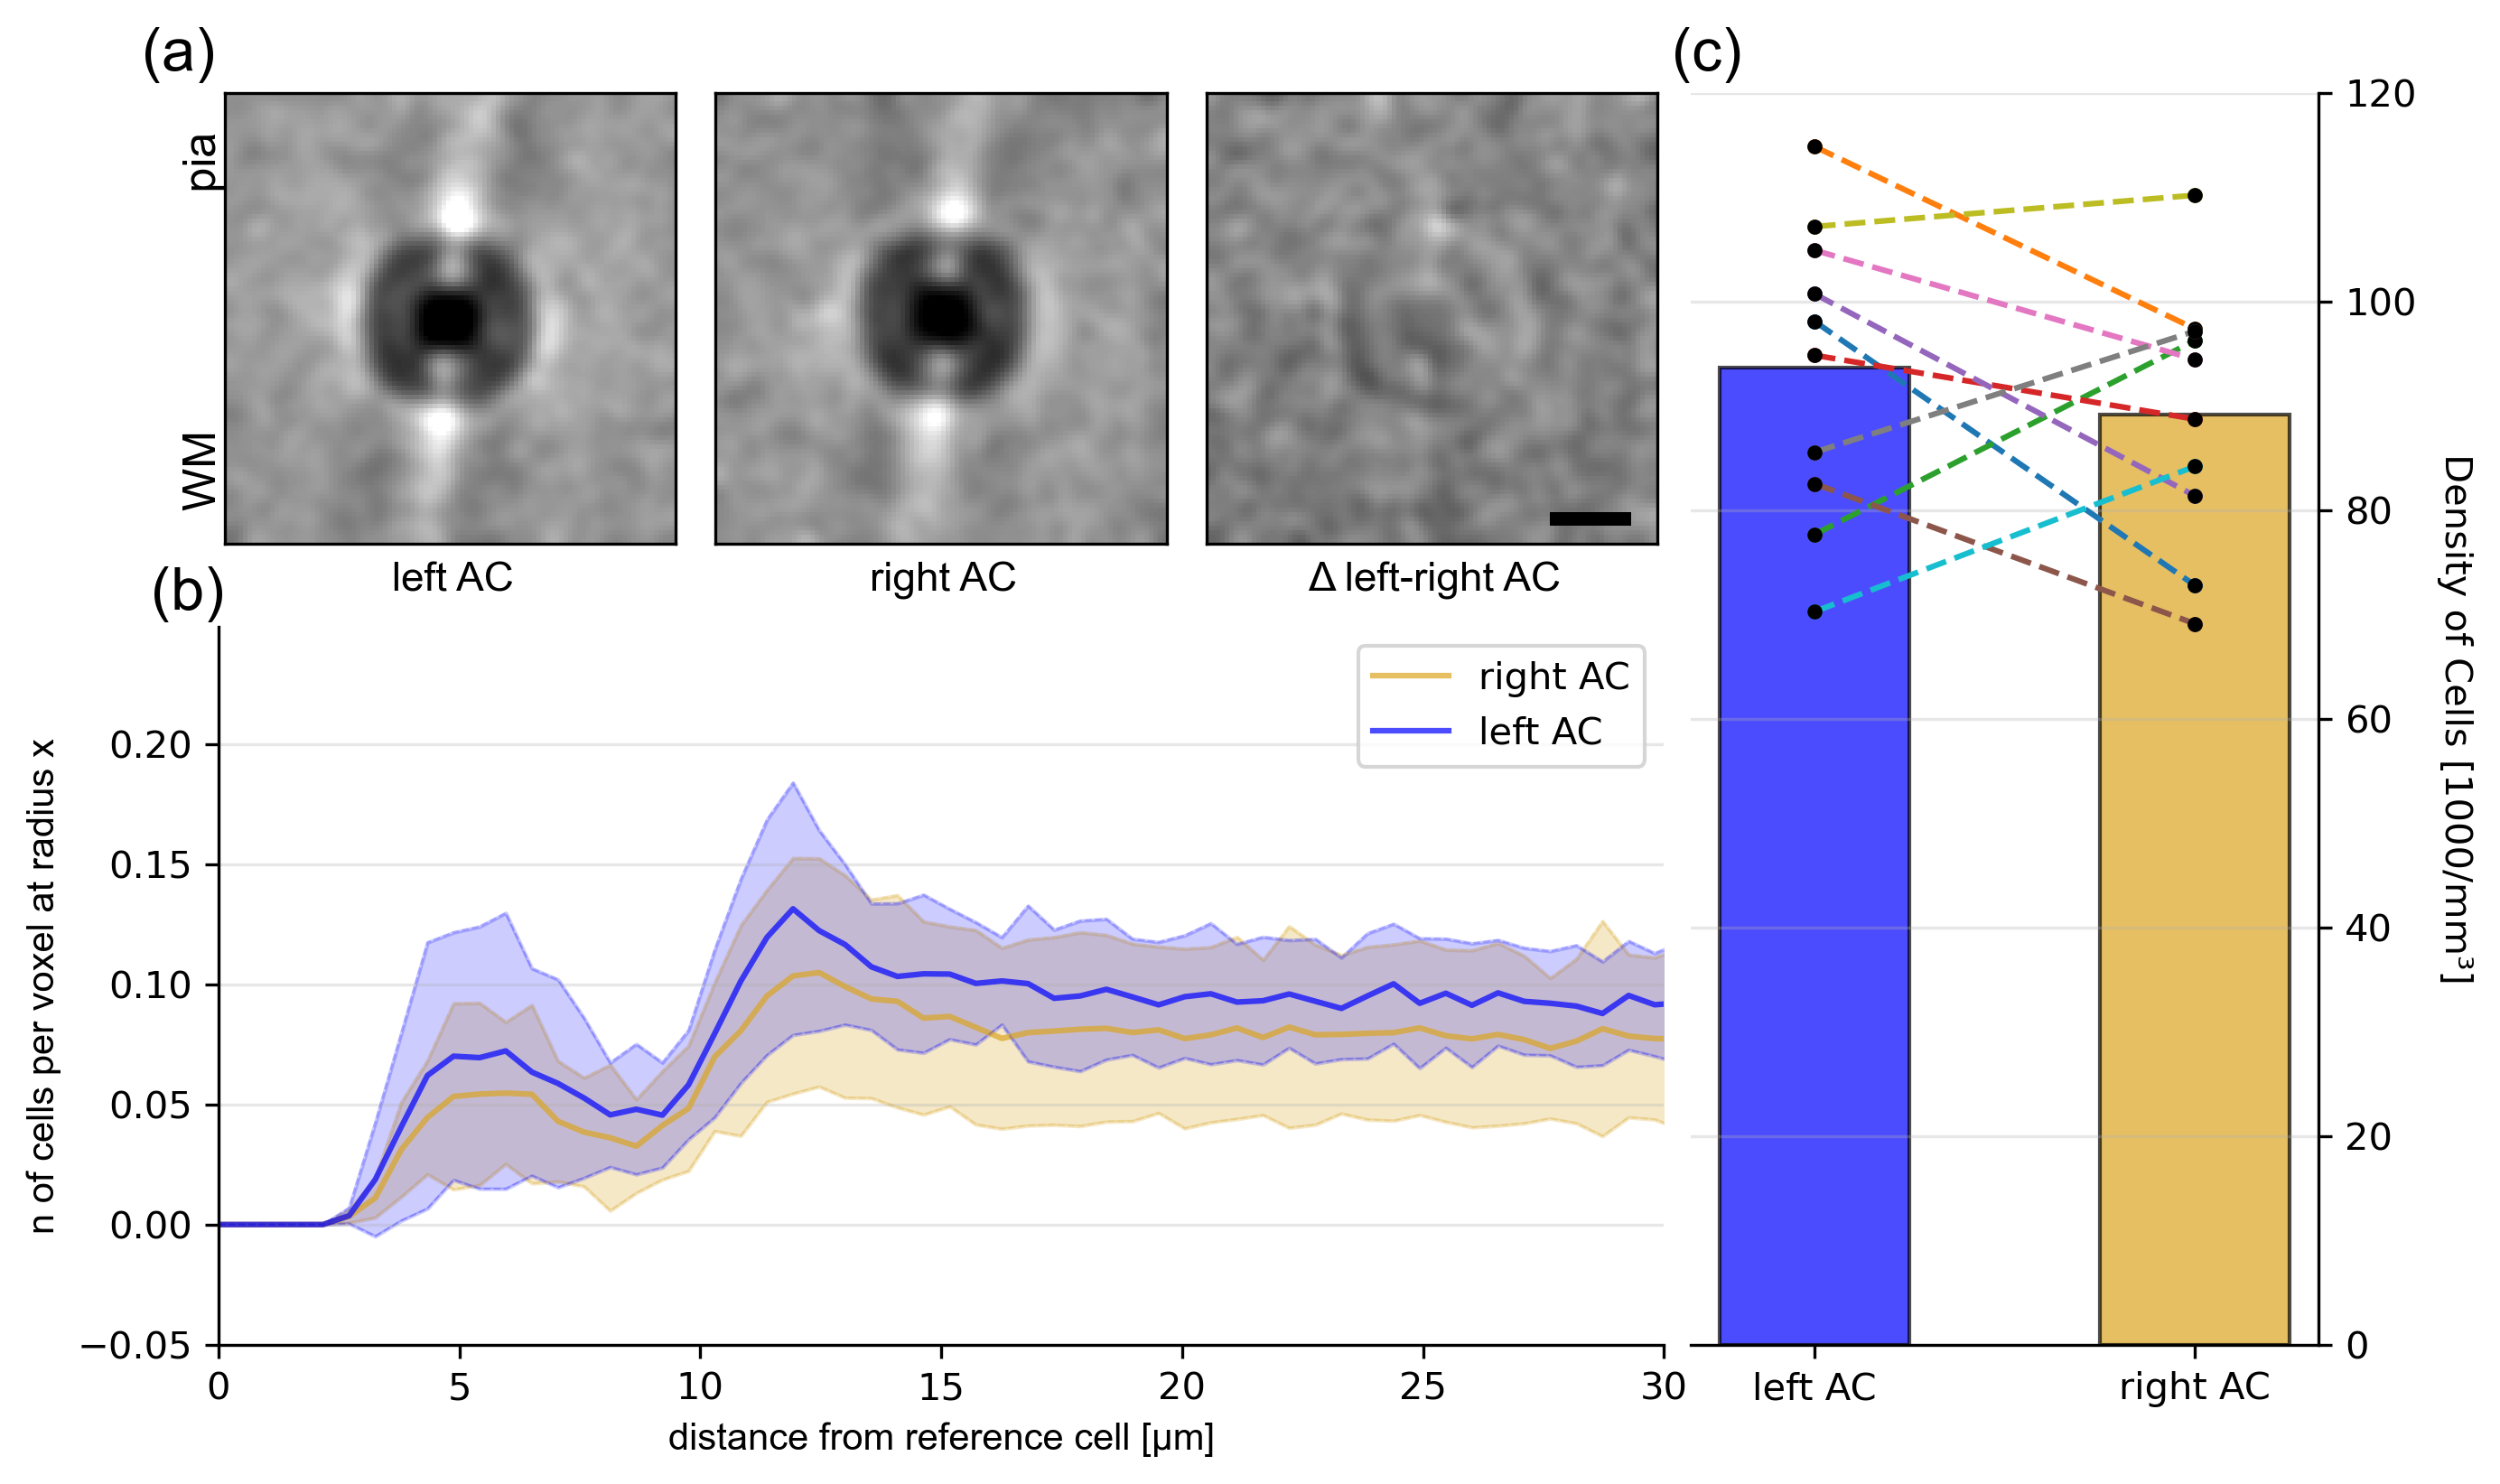

In [82]:
# import pylustrator
# pylustrator.start()

ax = plt.figure(figsize=(10,6),dpi=300).subplot_mosaic(
    """
    AAABBBCCCDDDD
    AAABBBCCCDDDD
    EEEEEEEEEDDDD
    EEEEEEEEEDDDD
    EEEEEEEEEDDDD
    """)

# A
# plot average 
ax["A"].imshow(avg_left[avg_left.shape[0]//2,:,:],vmin=vmin_avg,vmax=vmax_avg, cmap="gray")
ax["A"].set_xticks([])
ax["A"].set_yticks([])
ax["A"].text(50, 110, 'left AC', ha='center',fontsize=11,font="Arial")# transform=ax.transAxes)
ax["A"].text(-5, avg_left.shape[1]//2, 'WM                   pia', ha='center', va='center', rotation=90, fontsize=12,font="Arial")

# B
ax["B"].imshow(avg_right[avg_right.shape[0]//2,:,:],vmin=vmin_avg,vmax=vmax_avg, cmap="gray")
ax["B"].set_xticks([])
ax["B"].set_yticks([])
ax["B"].text(50, 110, 'right AC', ha='center',fontsize=11,font="Arial")# transform=ax.transAxes)

delta = avg_left[avg_left.shape[0]//2,:,:]-avg_right[avg_right.shape[0]//2,:,:]
scale_bar = np.zeros_like(delta)
scale_bar[93:96,76:94] = 1

# B
ax["C"].imshow(delta,vmin=vmin_avg,vmax=vmax_avg, cmap="gray")
ax["C"].imshow(np.ma.array(scale_bar, mask=scale_bar==0), interpolation='none', cmap='gray',vmax=1)
ax["C"].set_xticks([])
ax["C"].set_yticks([])
ax["C"].text(50, 110, u'Δ left-right AC', ha='center',fontsize=11,font="Arial")# transform=ax.transAxes)

# D
ax["D"].bar(labels, (avg_density_left/1000, avg_density_right/1000), alpha=0.7, width=0.5, color=['blue', 'goldenrod'], edgecolor="black")
ax["D"].set_ylim(0, 120)
ax["D"].spines['top'].set_visible(False)
ax["D"].spines['left'].set_visible(False)
ax["D"].yaxis.grid(True, alpha=0.3)
ax["D"].yaxis.tick_right()
ax["D"].yaxis.set_label_position("right")
ax["D"].set_ylabel("Density of Cells [1000/mm³]", rotation=-90, labelpad=15)
for i in range(len(densities_l)):
    ax["D"].plot((densities_l[i]/1000, densities_r[i]/1000), marker=".", linestyle='--', color=plt.cm.tab10(i))
    ax["D"].plot((densities_l[i]/1000, densities_r[i]/1000), marker=".", linestyle='None', color='black')

# E
# Right AC with shaded area
ax["E"].plot(x_values, list_distance_right[:60], color="goldenrod", label="right AC", alpha=0.7, lw=1.5)
ax["E"].fill_between(x_values, list_distance_right[:60] - list_std_right[:60], list_distance_right[:60] + list_std_right[:60], color="goldenrod", alpha=0.25)
ax["E"].plot(x_values, list_distance_right[:60] - list_std_right[:60], color="goldenrod", linestyle='--', linewidth=0.5, alpha=0.2)
ax["E"].plot(x_values, list_distance_right[:60] + list_std_right[:60], color="goldenrod", linestyle='--', linewidth=0.5, alpha=0.2)

# Left AC with shaded area
ax["E"].plot(x_values, list_distance_left[:60], color="blue", label="left AC", alpha=0.7, lw=1.5)
ax["E"].fill_between(x_values, list_distance_left[:60] - list_std_left[:60], list_distance_left[:60] + list_std_left[:60], color="blue", alpha=0.2)
ax["E"].plot(x_values, list_distance_left[:60] - list_std_left[:60], color="blue", linestyle='--', linewidth=0.5, alpha=0.2)
ax["E"].plot(x_values, list_distance_left[:60] + list_std_left[:60], color="blue", linestyle='--', linewidth=0.5, alpha=0.2)

ax["E"].legend(loc="upper right")
ax["E"].spines['top'].set_visible(False)
ax["E"].spines['right'].set_visible(False)
ax["E"].set_xlabel("distance from reference cell [µm]",font="Arial")
ax["E"].set_ylabel("n of cells per voxel at radius x",font="Arial")
ax["E"].set_xlim((0,30))
ax["E"].set_ylim((-0.05,0.249))
ax["E"].yaxis.grid(True, alpha=0.3)

# add A-E labels (thanks pylustrator)
plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}
# getattr(plt.figure(1), '_pylustrator_init', lambda: ...)()
plt.figure(1).ax_dict["A"].text(-0.1837, 1.05, '(a)', transform=plt.figure(1).ax_dict["A"].transAxes, fontsize=16.,font="Arial")
plt.figure(1).ax_dict["B"].text(2.12, 1.05, '(c)', transform=plt.figure(1).ax_dict["B"].transAxes, fontsize=16.,font="Arial")
plt.figure(1).ax_dict["C"].text(-2.34, -0.1455, '(b)', transform=plt.figure(1).ax_dict["C"].transAxes, fontsize=16.,font="Arial")
plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}

plt.subplots_adjust(wspace=0.2,hspace=0.45)
plt.show()